In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%store -r

/home/maarten/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


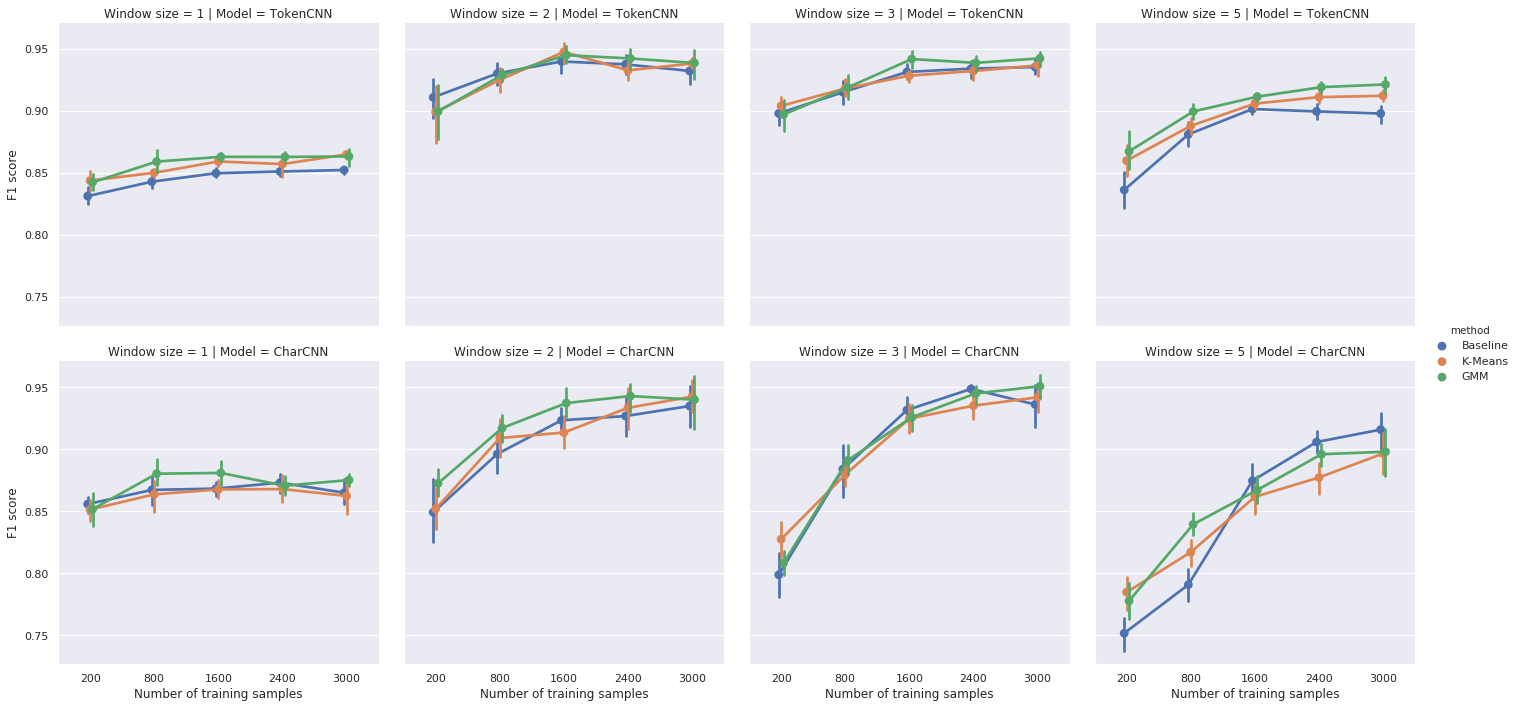

In [3]:
sns.set()

df = pd.concat([df_window0, df_window1, df_window2, df_window4])
df.window += 1

# fix the indices, which are fucked up by concat
df = df.reset_index(drop=True)

g = sns.catplot(
    x="size", y="score", data=df, kind="point", hue="method", row="model", col="window",
    dodge=True,
)
g.set_axis_labels("Number of training samples", "F1 score")
g.set_titles(col_template="Model = {row_name}", row_template="Window size = {col_name}")

plt.savefig("all_results.pdf")

In [4]:
from scipy.stats import ttest_rel

def p(s):
    i = s.keys()[0]
    size = df.iloc[i]["size"]
    method = df.iloc[i]["method"]
    model = df.iloc[i]["model"]
    window = df.iloc[i]["window"]

    baseline_scores = df[(df["size"] == size) & (df["model"] == model) & (df["method"] == "Baseline") & (df["window"] == window)].score
    scores = s.tolist()
    return ttest_rel(baseline_scores, scores)[1]

In [39]:
import tabulate

def p_table(sizes=[200, 800, 1600, 2400, 3000], window_sizes=[1, 2, 3, 5]):
    table = []
    bl_token, bl_char = None, None
    for method in ["Baseline", "K-Means", "GMM"]:
        p_token = df[(df.method == method) & (df.model == "TokenCNN") & (df["size"].isin(sizes)) & (df["window"].isin(window_sizes))]["score"]
        p_char = df[(df.method == method) & (df.model == "CharCNN") & (df["size"].isin(sizes)) & (df["window"].isin(window_sizes))]["score"]

        if method == "Baseline":
            bl_token = p_token
            bl_char = p_char

        table.append(
            [
                method,
                p_token.mean(),
                ttest_rel(bl_token, p_token)[1],
                p_char.mean(),
                ttest_rel(bl_char, p_char)[1],
            ]
        )
    
    return tabulate.tabulate(table)

print(p_table())
print(p_table([2400, 3000], [2, 3]))

--------  --------  -------------  --------  ------------
Baseline  0.895455  nan            0.879835  nan
K-Means   0.900746    2.54573e-05  0.880403    0.805214
GMM       0.905177    6.12767e-13  0.888337    0.00011621
--------  --------  -------------  --------  ------------
--------  --------  -----------  --------  ----------
Baseline  0.934844  nan          0.936584  nan
K-Means   0.934981    0.958669   0.938184    0.723731
GMM       0.940567    0.0303996  0.944668    0.115825
--------  --------  -----------  --------  ----------


In [21]:
df["size"].unique()

array([ 200,  800, 1600, 2400, 3000])

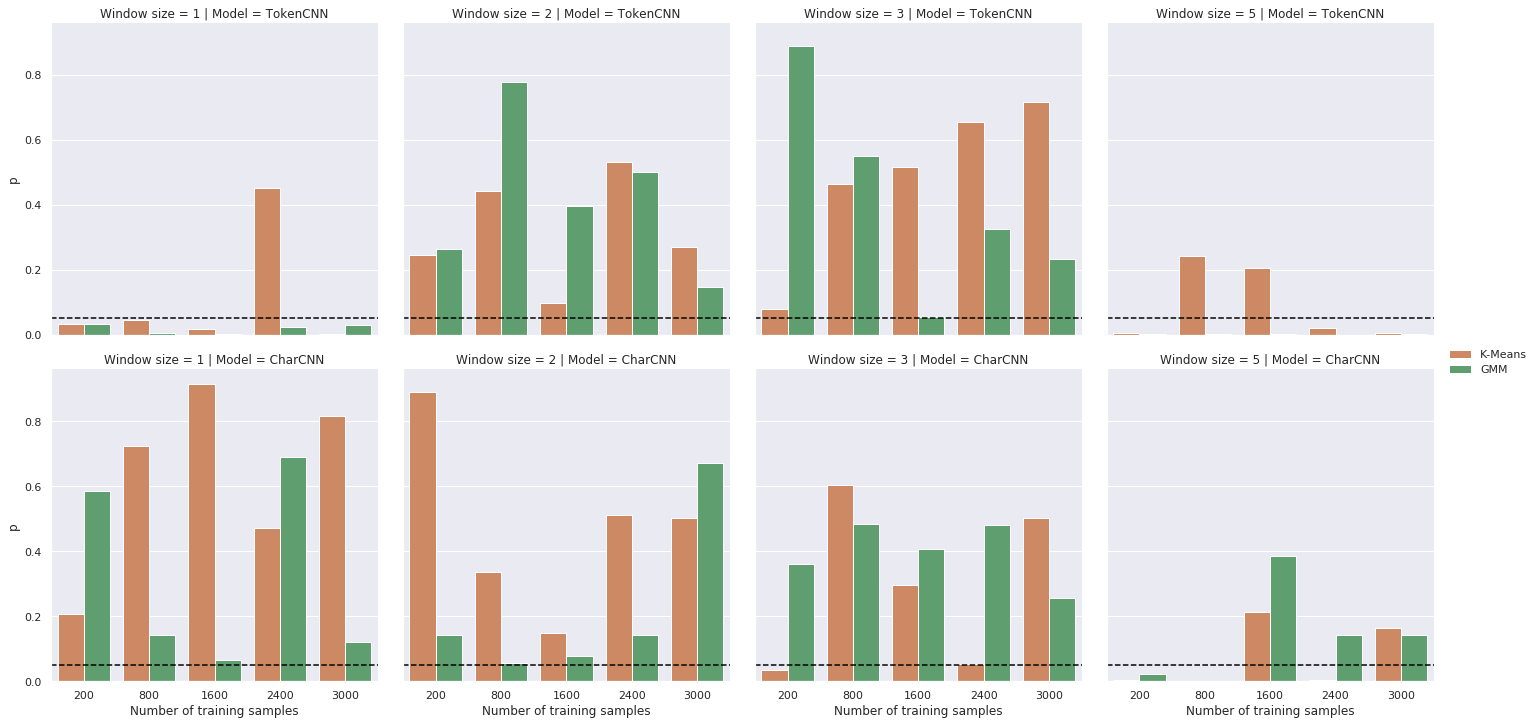

In [16]:
p_df = df.groupby(["window", "size", "model", "method"], sort=False).aggregate(p)
p_df = p_df.reset_index()

p_df = p_df[p_df["method"] != "Baseline"]
#g = sns.FacetGrid(p_df, col="model", row="window")
#g = g.map_dataframe(sns.barplot, x="size", y="score", hue="method")
g = sns.catplot(
    x="size", y="score", data=p_df, kind="bar", hue="method", row="model", col="window", legend=False,
    palette=sns.color_palette([(0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]),
)
g.map(plt.axhline, y=0.05, ls="--", c="black")
g.set_axis_labels("Number of training samples", "p")
g.set_titles(col_template="Model = {row_name}", row_template="Window size = {col_name}")
g.add_legend()
plt.savefig("all_results_p.pdf")